# Sentiment Analysis for Mental Health

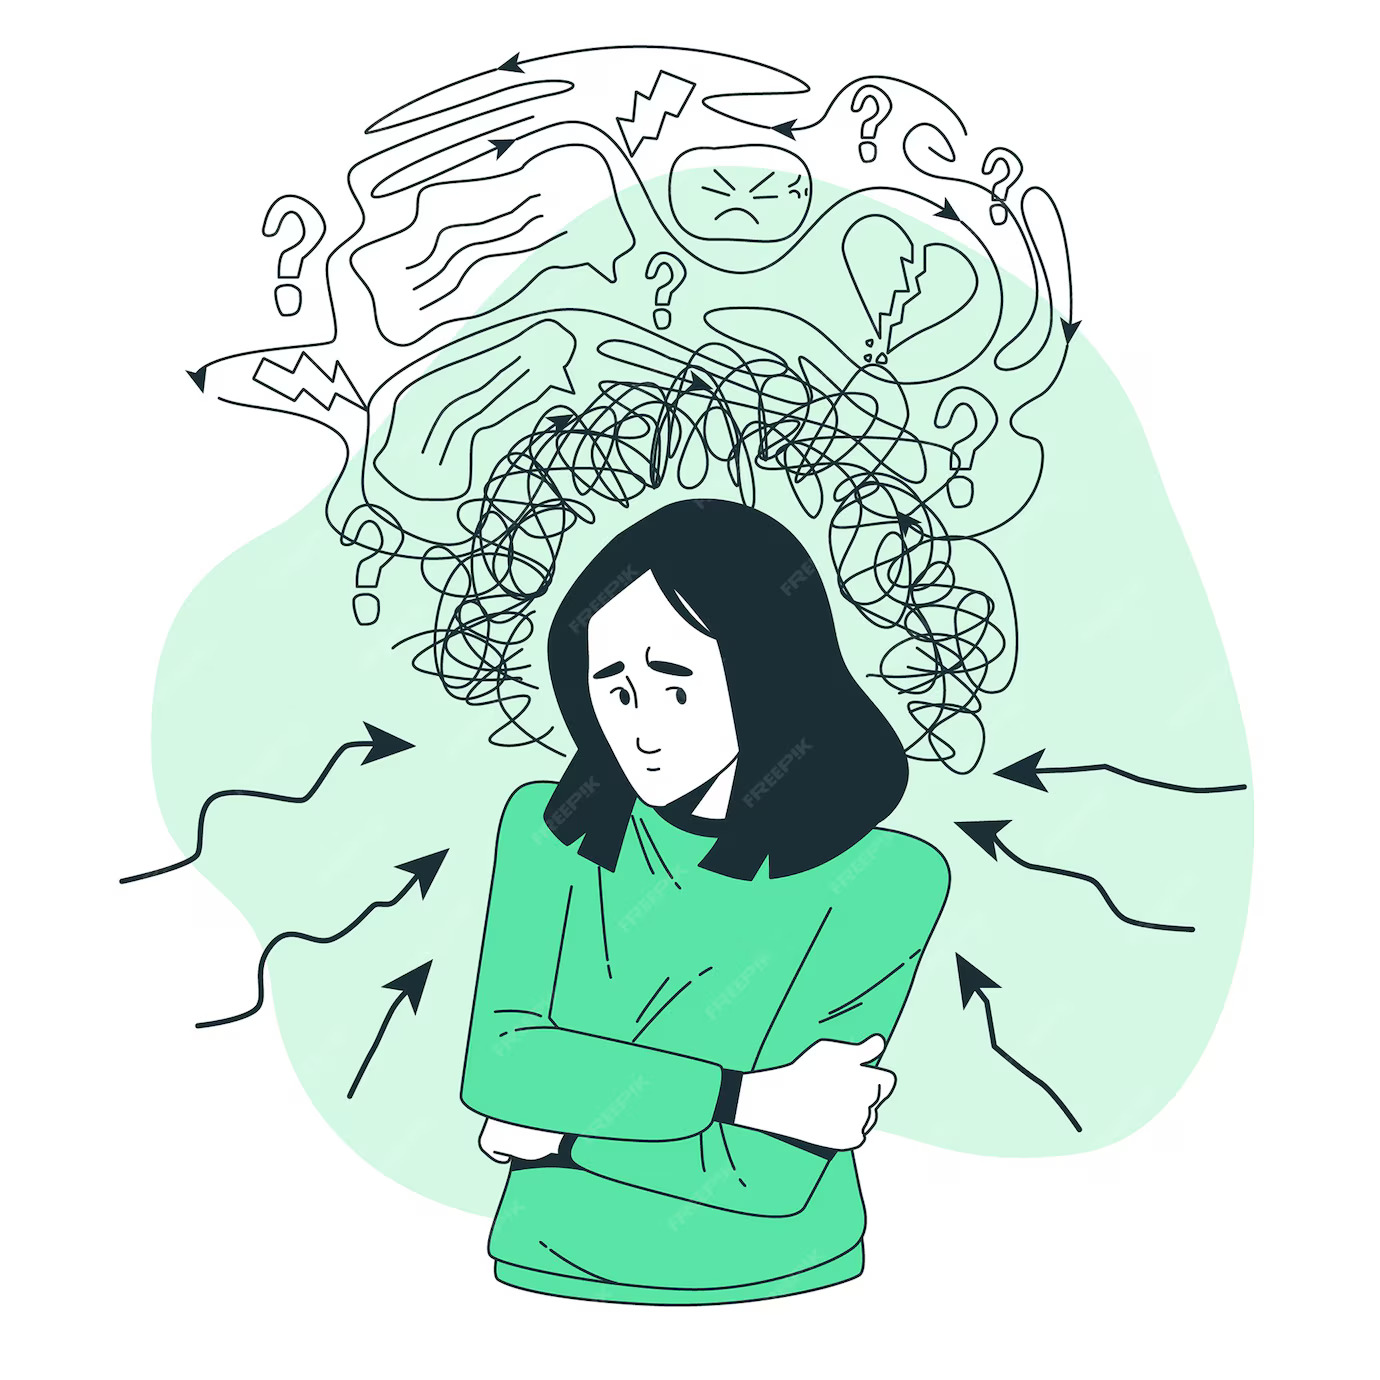

In [1]:
from PIL import Image
img = Image.open('anxiety-concept-illustration_114360-8074.jpg')
img

**Mental health is a critical aspect of overall well-being, and understanding the nuances of mental health conditions can be a powerful tool in providing timely support and interventions. In this project, I performed sentiment analysis on textual data to predict the mental health status of individuals based on their statements. By analyzing the language used in these statements, I aim to accurately classify them into one of seven mental health categories: Normal, Depression, Suicidal, Anxiety, Stress, Bi-Polar, and Personality Disorder.**

**By applying advanced natural language processing (NLP) technique Word2Vec and machine learning models, I seek to classify these statements accurately. The insights from this analysis could help mental health professionals in early identification and intervention.**

In [2]:
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np 
from tqdm import tqdm  # library used for simple and convenient way to add progress bars to loops and iterable objects

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

import random
import gensim
from wordcloud import WordCloud
from gensim.utils import simple_preprocess

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Combined Data.csv')
df = df.iloc[:,1:]
df = df[df['statement'].isnull()==False]
df = df.reset_index(drop=True)
df.head()

statement   status
0                                         oh my gosh  Anxiety
1  trouble sleeping, confused mind, restless hear...  Anxiety
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3  I've shifted my focus to something else but I'...  Anxiety
4  I'm restless and restless, it's been a month n...  Anxiety

# Exploratory Data Ananlysis 

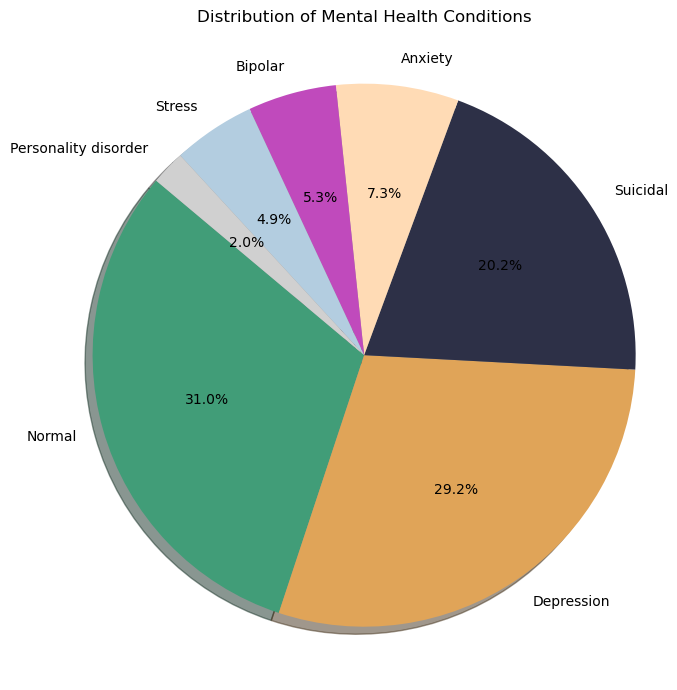

In [4]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

**The target variable in our dataset is unbalanced. This imbalance could affect our model's performance, so we'll need to address it later to ensure accurate and fair predictions.**

In [5]:
#Exploring at raw texts

# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: In anger,I pressed hard against my temples with most might. Is it gonna be fatal? My left temple is fine,I feel no pain but in right one I feel it’s swollen or has a dent,right side of my skull is feeling dizzy. Am I alright?

Status: Bipolar
Statement: Trileptal? in addition to lamotrigine (lamictal) (which has worked fantastic), my doctor JUST put me on trileptal. i was wondering what your experiences with it have been?! especially women in their early twenties. thank you so much. 

Status: Depression
Statement: Here lately I have been feeling very trapped. I do the same thing every week, go to work, watch tv, clean, take care of pets, etc. I am just exhausted of it I am exhausted of having to deal with shit but I am also tired of not doing shit. I used to work as a manager of a restaurant and it was exhausting and as much as I loved the restaurant itself I grew to hate going to work, so I quit. Now I am just a regular employee at a different restaurant and

In [6]:
# Calculate the number of characters and sentences
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [7]:
df[df['num_of_characters'] > 10000]

statement  \
7841   So introduction I guess.. my name is Michael a...   
9406   AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...   
9494   Hello everyone,I rarely post on Reddit but.......   
10824  I have only 1 person I can somewhat open to bu...   
11527  The title is not meant to discourage others, b...   
11571  I no longer know what else to do but write thi...   
11626  And has life gotten better?&amp;#x200B;No. Eve...   
11821  Sorry this is long but I doubt anyone will eve...   
13283  I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...   
18205  I am someone living in Turkey. My age is proba...   
21386  will i ever be noticed? is my life worth anyth...   
21848  I constantly repeat to myself that I have neve...   
22233  I do not expect anyone to read this rambly mes...   
22553  I have been thinking about posting online for ...   
23810  I need support or encouragement. I (29M) reall...   
23835  This is a a vent. I (29M) really do not know w...   
39740  it doesn t matter anymore i m going to copy an...   
46648  DEPRESSION HAS A PURPOSE: HOW TO USE IT RIGHT ...   
51127  Please help me understand what I went through ...   

                     status  num_of_characters  num_of_sentences  
7841             Depression              10679               136  
9406               Suicidal              25302                 1  
9494             Depression              11163               139  
10824              Suicidal              27390               237  
11527            Depression              12304               155  
11571            Depression              13530               140  
11626            Depression              12819                96  
11821            Depression              11122               155  
13283              Suicidal              32759              1260  
18205              Suicidal              10219               180  
21386            Depression              12298               160  
21848            Depression              13054               149  
22233              Suicidal              12227               118  
22553              Suicidal              12028               132  
23810            Depression              11111               127  
23835              Suicidal              11075               133  
39740            Depression              19822                 1  
46648               Bipolar              26163               430  
51127  Personality disorder              27588               374

**We have several lengthy messages, most of which express suicidal thoughts or signs of depression:**

In [8]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

statement   status  \
0                                         oh my gosh  Anxiety   
1  trouble sleeping, confused mind, restless hear...  Anxiety   
2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3  I've shifted my focus to something else but I'...  Anxiety   
4  I'm restless and restless, it's been a month n...  Anxiety   

   num_of_characters  num_of_sentences  \
0                 10                 1   
1                 64                 2   
2                 78                 2   
3                 61                 1   
4                 72                 2   

                                              tokens  
0                                     [oh, my, gosh]  
1  [trouble, sleeping, ,, confused, mind, ,, rest...  
2  [All, wrong, ,, back, off, dear, ,, forward, d...  
3  [I, 've, shifted, my, focus, to, something, el...  
4  [I, 'm, restless, and, restless, ,, it, 's, be...

In [9]:
#Word Clouds

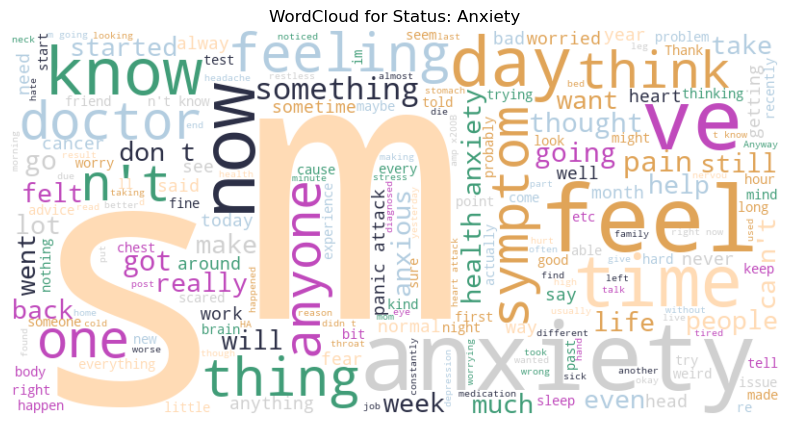

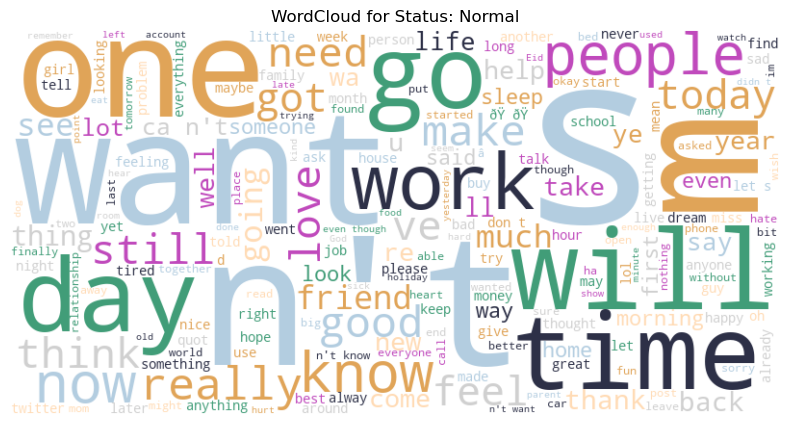

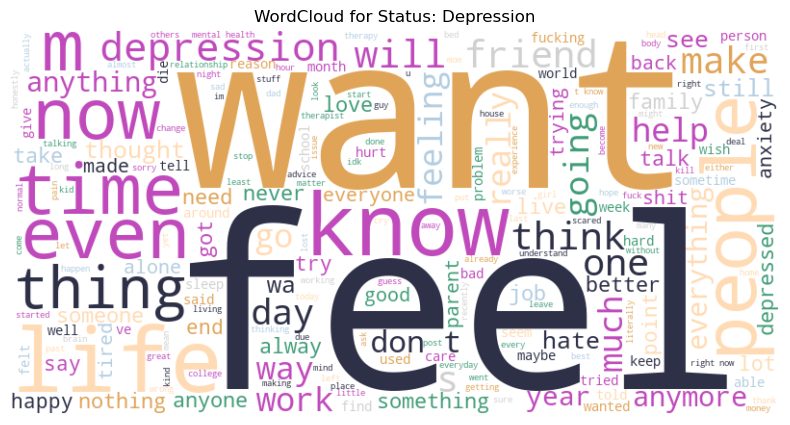

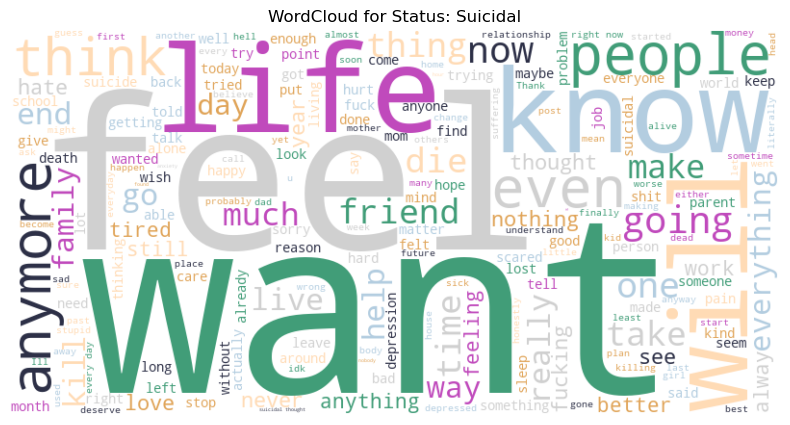

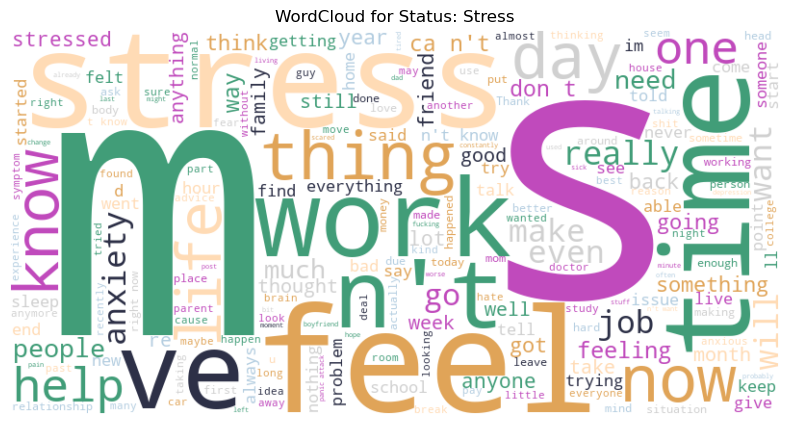

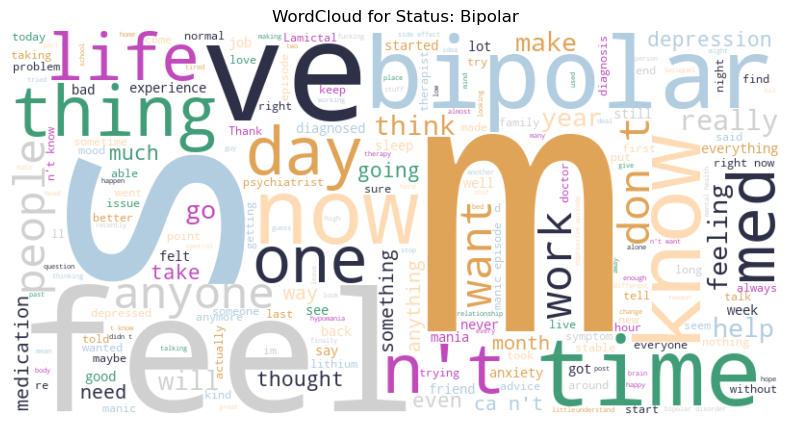

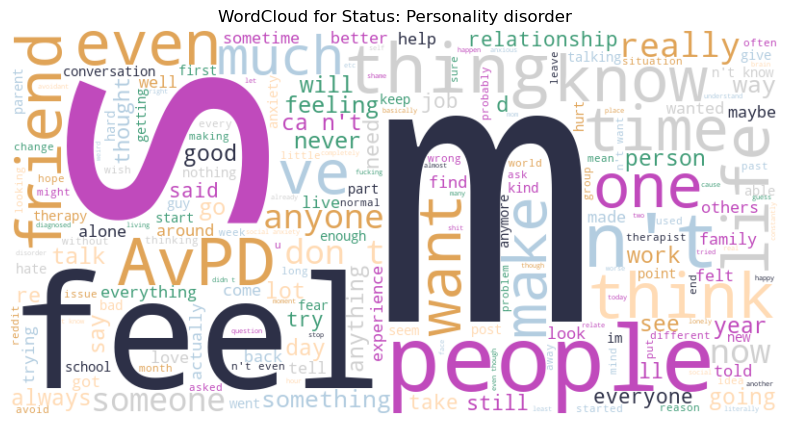

In [10]:
# Get unique categories in 'status'
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

**There is a significant overlap in the language used for discussing depression and suicidal thoughts in our data. Many terms and phrases are used interchangeably or similarly for both conditions, which may complicate the distinction between them.**

#  Word 2 Vec Implementation 

In [11]:
## pip install gensim  ##need to install this library if you have not already

In [12]:
lemmatizer=WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_text_lem(text):
    'Applying lemmetization and removing english stop words'
    cleaned_text = re.sub('[^a-zA-Z]', " ", text)
    cleaned_text = cleaned_text.lower()
    words = cleaned_text.split()
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    processed_text = " ".join(processed_words)
    return processed_text

In [13]:
batch_size = 10000
corpus = []

for start in range(0, len(df), batch_size):
    end = start + batch_size
    batch = df.iloc[start:end]
    batch['processed_text'] = batch['statement'].apply(process_text_lem)
    corpus.extend(batch['processed_text'].tolist())

In [14]:
# Lists to store indices and tokens
empty_token_indices = []  # List to store indices of empty tokens
words = []  # List to store non-empty tokens
appended_indices = []  # List to store indices of corpus items appended to words

for i, sent in enumerate(tqdm(corpus)):
    sent_token = sent_tokenize(sent)
    for sent in sent_token:
        tokens = simple_preprocess(sent, min_len=2, max_len=15)
        if not tokens:  # If the token list is empty
            empty_token_indices.append(i)  # Store the index
        else:
            words.append(tokens)
            appended_indices.append(i)  # Store the index of the original corpus

100%|█████████████████████████████████████████████████████████████████████████| 52681/52681 [00:03<00:00, 14284.52it/s]


In [15]:
# Convert appended_indices to a set for faster lookup
indices_to_keep = set(appended_indices)
# Filter the DataFrame to keep only rows whose index is in appended_indices
df_filtered = df[df.index.isin(indices_to_keep)]
# Alternatively, if you prefer to remove the rows not in appended_indices:
#df_filtered = df.drop(df.index.difference(appended_indices))

In [16]:
#Train the word 2 Vec from scratch
model_w2v = gensim.models.Word2Vec(words, window=7,min_count=5)

In [17]:
model_w2v.wv.index_to_key  #to check the vocabulary 

['like',
 'feel',
 'want',
 'know',
 'life',
 'get',
 'time',
 'even',
 'people',
 'would',
 'day',
 'year',
 'thing',
 'really',
 'one',
 'cannot',
 'going',
 'think',
 'go',
 'friend',
 'make',
 'much',
 'never',
 'help',
 'feeling',
 'could',
 'work',
 'thought',
 'anymore',
 'anxiety',
 'back',
 'anything',
 'way',
 'take',
 'still',
 'depression',
 'something',
 'good',
 'got',
 'always',
 'everything',
 'anyone',
 'need',
 'better',
 'every',
 'see',
 'nothing',
 'month',
 'someone',
 'also',
 'family',
 'bad',
 'since',
 'job',
 'hate',
 'right',
 'week',
 'say',
 'last',
 'love',
 'end',
 'live',
 'fucking',
 'getting',
 'keep',
 'talk',
 'die',
 'lot',
 'ever',
 'care',
 'everyone',
 'long',
 'person',
 'try',
 'trying',
 'tired',
 'point',
 'pain',
 'started',
 'hard',
 'around',
 'else',
 'well',
 'tell',
 'school',
 'first',
 'find',
 'away',
 'happy',
 'felt',
 'shit',
 'told',
 'alone',
 'come',
 'made',
 'tried',
 'parent',
 'said',
 'depressed',
 'ago',
 'stop',
 'sleep

In [18]:
model_w2v.wv.similar_by_word('education')   #function to check the similarty (sementic word) word in the given text data 

[('degree', 0.8409467339515686),
 ('academic', 0.8371315598487854),
 ('engineering', 0.8317472338676453),
 ('salary', 0.8263959288597107),
 ('scholarship', 0.8090580701828003),
 ('field', 0.8089975118637085),
 ('student', 0.8031349182128906),
 ('master', 0.795753538608551),
 ('finance', 0.7925668954849243),
 ('bachelor', 0.7885954976081848)]

In [19]:
#Now creating function for  Average word2vec for simpler model
def avg_word2vec(doc, model_w2v, vector_size):
    valid_words = [model_w2v.wv[word] for word in doc if word in model_w2v.wv.index_to_key]
    if len(valid_words) > 0:
        return np.mean(valid_words, axis=0)
    else:
        # Return a zero vector if no valid words are found
        return np.zeros(vector_size)

In [20]:
#apply Average Word2vec for the entire corpus
X = []
vector_size = model_w2v.vector_size  # Get the size of the word2vec vectors
for i in tqdm(range(len(words))):
    X.append(avg_word2vec(words[i], model_w2v, vector_size))

100%|███████████████████████████████████████████████████████████████████████████| 52497/52497 [01:02<00:00, 839.76it/s]


In [21]:
#X and y spit
X = np.array(X)
y = df_filtered['status']

In [22]:
# Label encoding target variable
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

# Train Test Split

In [23]:
#Train Test Split
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 9)

# Resampling
As we have seen above in EDA that in data distribution of classed are imbalanced hence I experimented with various resampling techniques, including SMOTE, Random Over-Sampling and Random Under-Sampling. Among these, Random Over-Sampling provided the best results.

In [24]:
# Apply Random Over-Sampling on data
ROS = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ROS.fit_resample(X_train, y_train)

In [25]:
X_train_resampled.shape

(89852, 100)

# Modelling
**Define a dictionary of classifiers with their specific parameters.**

In [26]:
# Note: The hyperparameters for these classifiers were chosen after performing GridSearchCV to optimize performance.
classifiers = {
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101), 
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101)
}



For Bernoulli Naive Bayes
Accuracy: 0.5085714285714286
                      precision    recall  f1-score   support

             Anxiety       0.47      0.62      0.54       811
              Normal       0.31      0.53      0.39       538
          Depression       0.55      0.25      0.34      2993
            Suicidal       0.82      0.69      0.75      3332
              Stress       0.10      0.57      0.17       216
             Bipolar       0.19      0.26      0.22       514
Personality disorder       0.51      0.59      0.55      2096

            accuracy                           0.51     10500
           macro avg       0.42      0.50      0.42     10500
        weighted avg       0.58      0.51      0.52     10500



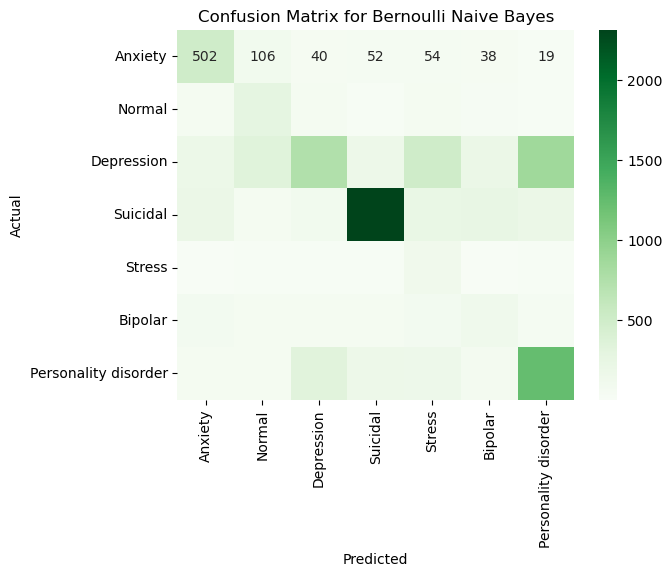



For Decision Tree
Accuracy: 0.444
                      precision    recall  f1-score   support

             Anxiety       0.40      0.57      0.47       811
              Normal       0.27      0.45      0.33       538
          Depression       0.49      0.21      0.29      2993
            Suicidal       0.81      0.57      0.67      3332
              Stress       0.11      0.55      0.18       216
             Bipolar       0.15      0.35      0.21       514
Personality disorder       0.45      0.54      0.49      2096

            accuracy                           0.44     10500
           macro avg       0.38      0.46      0.38     10500
        weighted avg       0.54      0.44      0.46     10500



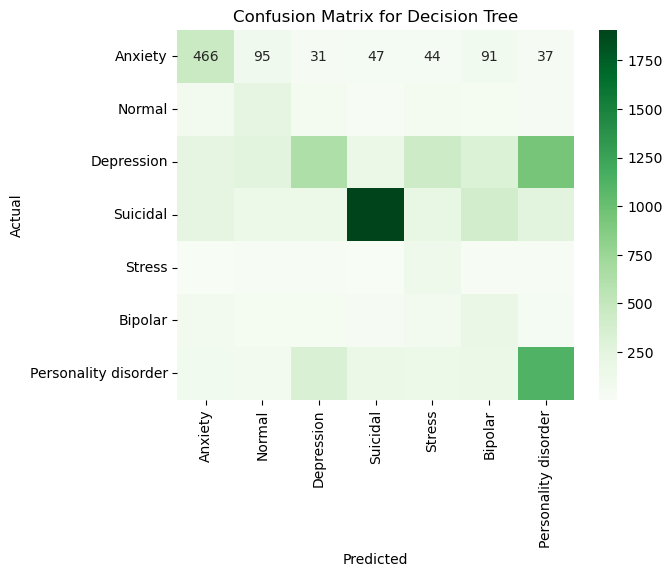



For Logistic Regression
Accuracy: 0.5639047619047619
                      precision    recall  f1-score   support

             Anxiety       0.57      0.74      0.64       811
              Normal       0.38      0.64      0.47       538
          Depression       0.70      0.33      0.45      2993
            Suicidal       0.83      0.65      0.73      3332
              Stress       0.14      0.69      0.24       216
             Bipolar       0.25      0.50      0.33       514
Personality disorder       0.58      0.67      0.62      2096

            accuracy                           0.56     10500
           macro avg       0.49      0.60      0.50     10500
        weighted avg       0.66      0.56      0.58     10500



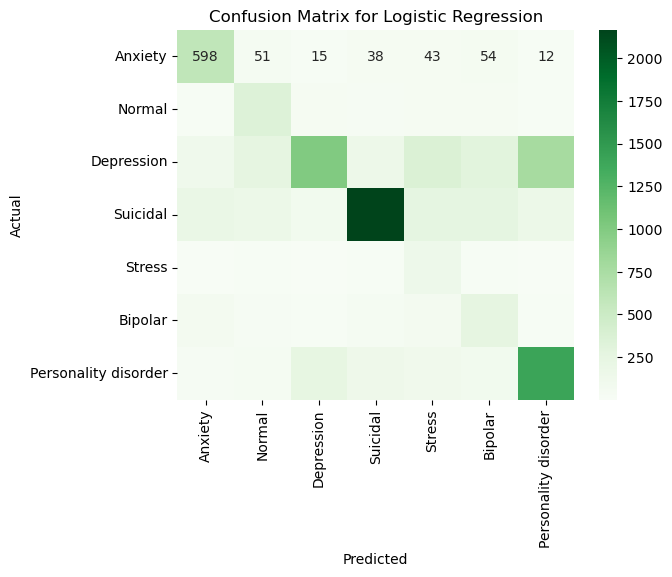



For XGB
Accuracy: 0.716
                      precision    recall  f1-score   support

             Anxiety       0.78      0.73      0.75       811
              Normal       0.68      0.58      0.63       538
          Depression       0.61      0.67      0.64      2993
            Suicidal       0.87      0.92      0.89      3332
              Stress       0.72      0.43      0.54       216
             Bipolar       0.64      0.40      0.49       514
Personality disorder       0.61      0.61      0.61      2096

            accuracy                           0.72     10500
           macro avg       0.70      0.62      0.65     10500
        weighted avg       0.71      0.72      0.71     10500



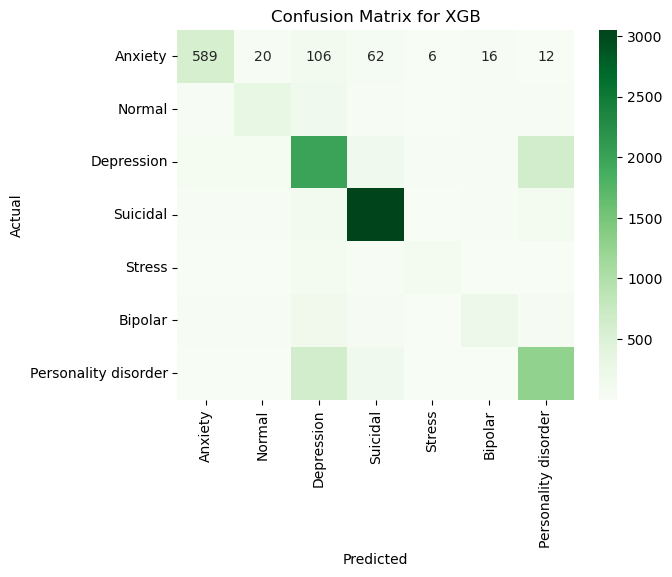

In [27]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)
    
    # Compute the confusion matrix for the predictions
    # 'lbl_enc.classes_' provides the class labels for the confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=df['status'].unique().tolist()))
    
    # Plot the confusion matrix using a heatmap
    # Annotate each cell with the numeric value of the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=df['status'].unique().tolist(), yticklabels=df['status'].unique().tolist())
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap
    
    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)

In [28]:
# Trying it on the new text

# New sentence to classify
new_sentence = input("Enter your new sentence here: ")

# Preprocess the new sentence
def preprocess_single_sentence(text):
    'Applying lemmetization and removing english stop words'
    cleaned_text = re.sub('[^a-zA-Z]', " ", text)
    cleaned_text = cleaned_text.lower()
    words = cleaned_text.split()
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    processed_text = " ".join(processed_words)
    return processed_text

processed_sentence = preprocess_single_sentence(new_sentence)

processed_sentence = simple_preprocess(processed_sentence, min_len=2, max_len=15)

# Step 3: Transform the sentence using the avg_word2vec function
new_sentence_vector = avg_word2vec(processed_sentence, model_w2v, vector_size).reshape(1, -1)  # Reshape to 2D array

# Make prediction using the trained model
prediction = clf.predict(new_sentence_vector)
prediction_proba = clf.predict_proba(new_sentence_vector)

# Map prediction to emotions
mental_state = {
    0: "Anxiety",
    1: "Bipolar",
    2: "Depression",
    3: "Normal",
    4: "Personality disorder",
    5: "Stress",
    6: "Suicidal"
}

for index, proba in enumerate(prediction_proba[0]):
    emotion = mental_state[index]
    print(f"{emotion}: {proba * 100:.2f}%")
print("Prediction probabilities of your current mental state is  :", mental_state[prediction[0]])

Enter your new sentence here:  I do the same thing every week, go to work, watch tv, clean, take care of pets, etc. I am just exhausted of it I am exhausted of having to deal with shit but I am also tired of not doing shit. I used to work as a manager of a restaurant and it was exhausting and as much as I loved the restaurant itself I grew to hate going to work, so I quit. Now I am just a regular employee at a different restaurant and I can barely survive bc I make no money.


Anxiety: 0.01%
Bipolar: 0.05%
Depression: 97.57%
Normal: 1.07%
Personality disorder: 0.00%
Stress: 0.10%
Suicidal: 1.21%
Prediction probabilities of your current mental state is  : Depression


# In our project, I evaluated four models designed to handle large datasets with numerous features with the help of Word2Vec: Bernoulli Naive Bayes, Decision Tree, Logistic Regression, and XGBoost (XGB). XGBoost emerged as the top performer with an accuracy of 72%. The classification report showed that the Suicidal state was the easiest to distinguish with an F1 score of 89, followed by Anxiety with F1 scores of 85. Other states also performed well, with F1 scores above 50. Although the Confusion Matrix and WordCloud analysis revealed some overlap between depression and suicidal messages, XGBoost still outperformed the other models and demonstrated superior overall performance.